In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [125]:
df= pd.read_csv("../modelling/predictions/22-08-26/few_slices_for_EA-17:55:12.csv")
#df= pd.read_csv("../modelling/predictions/22-08-26/few_slices_for_EA-17:49:46.csv")

df["Sex"].fillna(df["M/F"], inplace=True)
keep_cols = ['ID', 'Age', 'CDR', 'label', 'Group', 'Sex', 'y_test', 'y_pred', 'y_pred_probs']
df= df[keep_cols]

df.sample(10)

,ID,Age,CDR,label,Group,Sex,y_test,y_pred,y_pred_probs
124,033_S_0724,79,NaN,1,AD,M,1,0,0.343085
16,141_S_1137,82,NaN,1,AD,F,1,1,0.888515
31,036_S_1001,69,NaN,1,AD,M,1,1,0.738908
78,128_S_0805,86,NaN,1,AD,M,1,1,0.581853
71,OAS1_0124_MR1,73,1.0,1,NaN,M,1,0,0.396634
50,OAS1_0113_MR1,83,0.0,0,NaN,F,0,0,0.092984
83,131_S_0436,85,NaN,0,CN,M,0,0,0.487400
25,130_S_0956,64,NaN,1,AD,F,1,0,0.238179
127,002_S_0816,71,NaN,1,AD,M,1,0,0.355328
75,OAS1_0374_MR1,73,1.0,1,NaN,F,1,0,0.172505


In [126]:
TP = df[(df.label == 1) & (df.y_pred == 1)]
FP = df[(df.label == 0) & (df.y_pred == 1)]
TN = df[(df.label == 0) & (df.y_pred == 0)]
FN = df[(df.label == 1) & (df.y_pred == 0)]

acc =round((TP.shape[0]+TN.shape[0])/(TP.shape[0]+FP.shape[0]+TN.shape[0]+FN.shape[0]),2)
recall= round((TP.shape[0])/(TP.shape[0]+FN.shape[0]),2)
try:
    precision= round((TP.shape[0])/(TP.shape[0]+FP.shape[0]),2)
except:
    precision = 0.0
print(f"Accuracy is {acc}, \nRecall is {recall}, \nPrecision is {precision}")

Accuracy is 0.64, 
Recall is 0.66, 
Precision is 0.62


In [127]:
def classification(row):
    if (row.label == 1) & (row .y_pred == 1):
        return "TP"
    if (row.label == 0) & (row .y_pred == 1):
        return "FP"
    if (row.label == 0) & (row .y_pred == 0):
        return "TN"
    if (row.label == 1) & (row .y_pred == 0):
        return "FN"

df["classification"] = df.apply(lambda row: classification(row), axis=1)

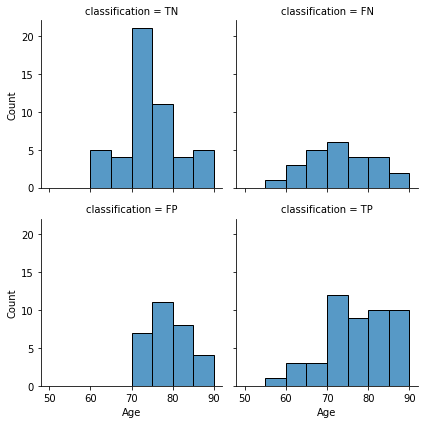

In [128]:
plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.histplot, x="Age", binrange=(50,90), binwidth=5);

In [129]:
'''plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.histplot, x="CDR_", binrange=(0,3), binwidth=0.2)''';

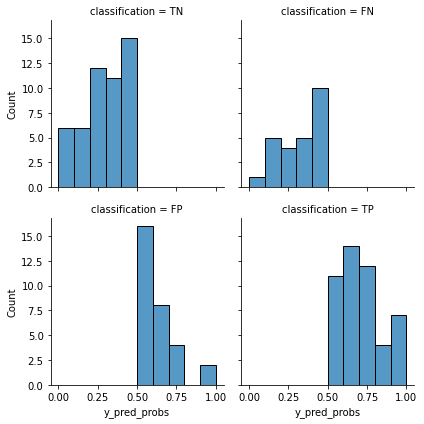

In [130]:
plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.histplot, x="y_pred_probs", binrange=(0,1), binwidth=0.1);

In [131]:
#df= df[df["classification"]=="FN"]

In [132]:
df.sort_values("y_pred_probs", inplace=True)
df= df.reset_index(drop=True)
df["order"] = df.index

/Users/valentin/neuefische/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [133]:
df.sort_values("ID", ascending=False, inplace=True)
df.iloc[22]

ID                033_S_0724
Age                       79
CDR                      NaN
label                      1
Group                     AD
Sex                        M
y_test                     1
y_pred                     0
y_pred_probs        0.343085
classification            FN
order                     10
Name: 10, dtype: object

In [134]:
df_o = df[df['ID'].str.contains("OAS1", case=False)]
df_a = df[df['ID'].str.contains("_S_", case=False)]

IDs_o = df.loc[df['ID'].str.contains("OAS1", case=False)]["ID"]
IDs_a = df.loc[df['ID'].str.contains("_S_", case=False)]["ID"]

In [135]:
sys.path.append('../')
from preprocessing.getdata import *

imgs = get_slices_both(OASIS_IDs =IDs_o, ADNI_IDs =IDs_a, dim=2, m=90, normalize=False)
#imgs= get_slices(IDs_o, dim=2, m=90, normalize=False)
#imgs= get_slices_ADNI(IDs_a, dim=2, m=90, normalize=False)
imgs.shape

(25, 176, 208)

In [136]:
order= np.array(df["order"])
sort = order.argsort()
imgs_sorted= imgs[sort]

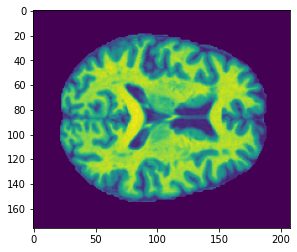

In [137]:
#most confident CN
plt.imshow(imgs_sorted[0])

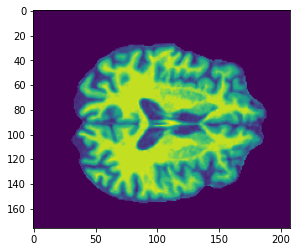

In [138]:
#most confident AD
plt.imshow(imgs_sorted[-1])

In [139]:
from matplotlib import animation


# generating gif out of slices of 3-dimensional numpy array
def generate_gif(numpy_3d_array, path="test.gif"):
    fig = plt.figure()
    im = plt.imshow(numpy_3d_array[0, :, :],    # display first slice
                    animated=True,
                    cmap='turbo',               # color mapping
                    vmin=0, # lowest value in numpy_3d_array
                    vmax=1) # highest value in numpy_3d_array
    plt.colorbar(label='turbo', shrink=0.75)
    plt.tight_layout()

    def init():
        im.set_data(numpy_3d_array[0, :, :])
        return im,

    def animate(i):
        im.set_array(numpy_3d_array[i, :, :])
        return im,

    # calling animation function of matplotlib
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=np.shape(numpy_3d_array)[0],  # amount of frames being animated
                                   interval=500,                       # update every second
                                   blit=True)
    anim.save(path)   # save as gif
    plt.show()

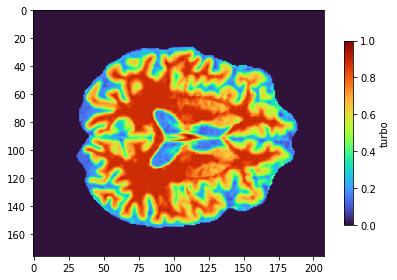

In [140]:
generate_gif(imgs_sorted, path="./gifs/combined.gif")

In [141]:
imgs_sorted.max()

1.0